In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from line_profiler import LineProfiler

from gaez_data_loader import GlobalAezV4
import simulation
import toolbox
import importlib
importlib.reload(simulation)
importlib.reload(toolbox)

<module 'toolbox' from 'C:\\Users\\leoko\\PycharmProjects\\pythonProject\\toolbox.py'>

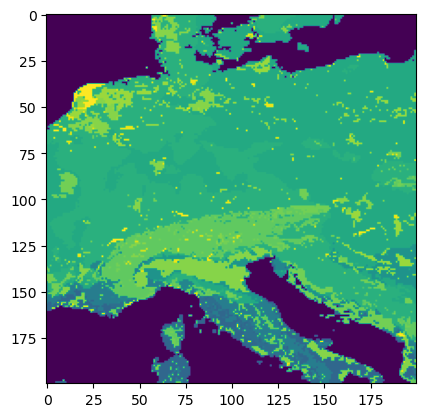

In [19]:
# Load GAEZ data

data_dir = r"C:\Users\leoko\Documents\Vienna_CSH\gaez_v4_data"
fn = "aez_33_classes_low_res.tif"

gaez_data = GlobalAezV4()
gaez_data.load(os.path.join(data_dir, fn), idx=0, verbose=False)
gaez_data.set_woi(r0=300, c0=2000, n_rows=400, n_cols=600) # crop europe
gaez_data.get_distance_matrix() # load distance matrix

test_data = np.copy(gaez_data._array[100:300, 200:400])

plt.imshow(test_data) # visualize

In [20]:
# Parameters
num_rows, num_cols = test_data.shape
num_vars = 10 # number of env. variables
p_0 = 800 # Basic productivity - sets max. population for a single village
pop_min, pop_max = 10, 20 # Min and max population for a village to split

# Updating the population dynamics
sim_steps = 5_000
rate = 1 / 30 # Growth coefficient in equation (1) - denotes time

# If too small, population will overshoot and array will get clipped.
# For an env. vector of length N, the worst prod. is zero, and the next-worst prod. is 1 / N
# So a reasonable setting is 1 / (4 * N) * p_0 imo
# p_min = 1 / (8 * num_vars) * p_0
p_min = 0 # If None, population gets clipped to zero in each update of the logistic ODE

# Single lattice with seed 50
lattice = simulation.Lattice(n_rows=num_rows, n_cols=num_cols, steps_sim=sim_steps, seed=50, idx_start=(100, 100),
                             num_env_vars=num_vars, pop_min=pop_min, pop_max=pop_max, env=test_data,
                             rate_growth=rate, prod_min=p_min, rate_prod=p_0)

In Lattice.init().: To avoid negative population, clip population to zero.
In Lattice.init_env_from_gaez(): Input environment contains water. Set to zero. Ensure that productivity settlement threshold is above 1 to avoid settling water.
Cell productivity varies in steps 42.10526315789474. In case of GAEZ env., this is also the maximum productivity.


In [21]:
# Run with line profiler
profiler_line = LineProfiler()
profiler_line.enable_by_count()
profiler_line.add_function(lattice.migrate_to)

lattice.set_search_params(prod_threshold=1, neigh_type="von_neumann", distance=25, search_intelligently=True)
lattice.set_evolution_params(env_mutation_rate=None, skill_mutation_rate=0.2, skill_mutates_randomly=False,
                             repopulate_empty_cells=True, metropolis_scale=10)

print("Env vector: ", lattice.env[lattice.r0, lattice.c0])

for _ in tqdm(range(5_000)):
    # print("Skill vector: ", lattice.skills[lattice.r0, lattice.c0])
    # print("Productivity: ", lattice.prod[lattice.r0, lattice.c0])
    lattice.move_forward()
    lattice.num_iter += 1

profiler_line.print_stats()

Env vector:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


100%|█████████▉| 4999/5000 [02:49<00:00, 29.41it/s] 


IndexError: index 5000 is out of bounds for axis 0 with size 5000

In [3]:
# Run simulation
lattice.set_search_params(prod_threshold=10, neigh_type="von_neumann", distance=50, search_intelligently=True)
lattice.set_evolution_params(env_mutation_rate=0.001, skill_mutation_rate=0.01, skill_mutates_randomly=False,
                             repopulate_empty_cells=True, metropolis_scale=10)

lattice.run(disable_progress_bar=False)

TypeError: Lattice.run() got an unexpected keyword argument 'track_prod'

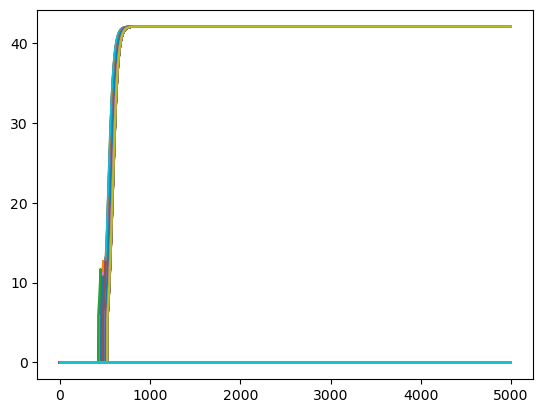

In [22]:
# Plot population of different cells
fig = plt.figure() # no NAN values

to_plot = lattice.population
for ii in range(10):
    plt.plot(to_plot[:, :, ii])

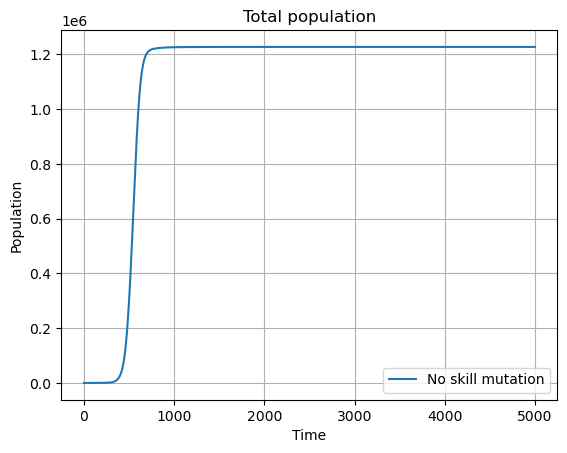

In [23]:
# Get entire population
fig = plt.figure()

pop_t = lattice.population

pop_t[np.isnan(pop_t)] = 0 # to clean for NaN values
pop_total = np.sum(pop_t, axis=(1, 2))

plt.plot(pop_total[:-1], label="No skill mutation")
plt.grid()
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Total population")
plt.legend()

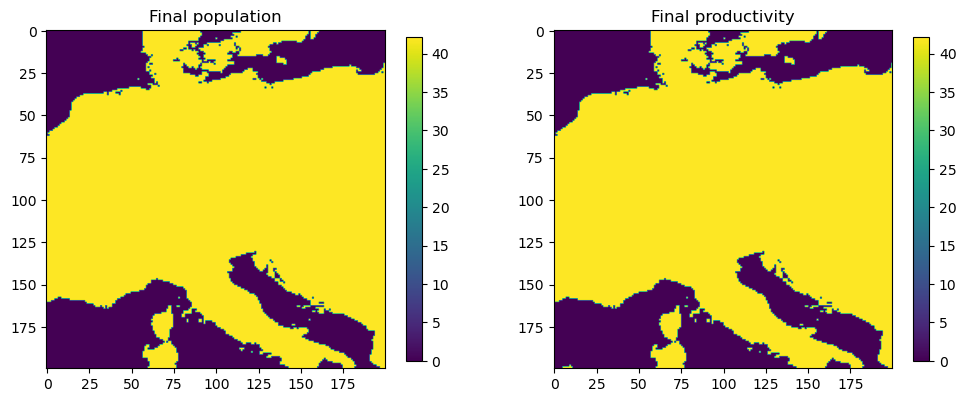

In [24]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plot1 = ax1.imshow(lattice.population[-1, :, :])
ax1.set_title("Final population")
fig.colorbar(plot1, ax=ax1, shrink=0.7)

plot2 = ax2.imshow(lattice.prod)
ax2.set_title("Final productivity")
fig.colorbar(plot2, ax=ax2, shrink=0.7)

[0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0.]


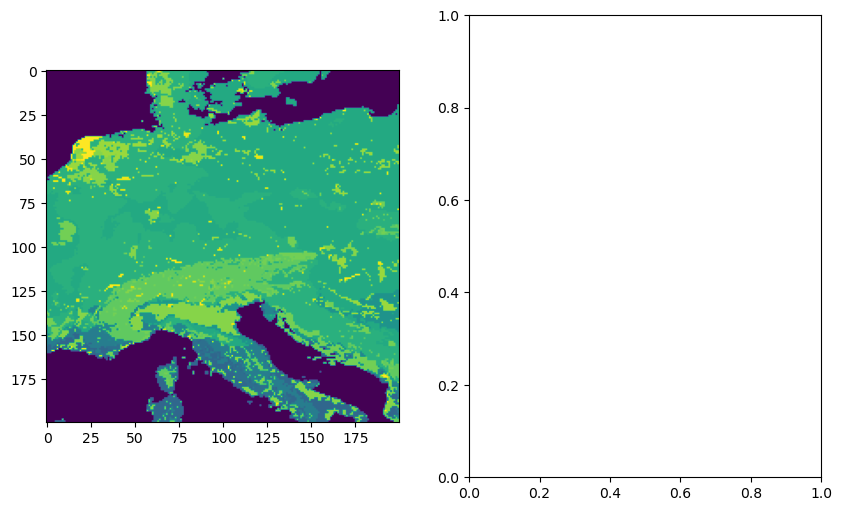

In [33]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 6))

# plot different skills
skills_plot = np.copy(lattice.skills)

# print(skills_plot[100, 100, :])
#  = np.argwhere(skills_plot != 0, axis=3)
# scaling_factors.reshape((200, 200))

ax1.imshow(test_data)
# ax2.imshow(lattice.ski)